__Importing Libraries__

In [3]:
from ultralytics import YOLO
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import cv2
from pprint import pprint

In [4]:
%run radar_camera_fusion.py

__Function to Process prediction results__

In [5]:
def class_box_generator_for_pred(prediction_results):
    for result in prediction_results:
        cls = result.boxes.cls.numpy()
        conf = result.boxes.conf.numpy()
        detection = result.boxes.xyxy.numpy()

        list_of_pred_boxes = np.column_stack((cls, detection, conf))
    
    #print(list_of_pred_boxes)
    return list_of_pred_boxes

In [6]:
def camera_to_ground(list_of_boxes, calibration_file):
    with open(calibration_file, 'r') as file:
        loaded_json = json.load(file)
        T_matrix = np.array(loaded_json['calibration'][5]['T'])

    points_data_for_ground_plane = []
    for detection in list_of_boxes:
        cls = detection[0]
        #top_left = np.array(list(detection[1:3])).reshape(1,-1)
        #right_bottom = np.array(list(detection[3:5])).reshape(1,-1)
        center_bottom = np.array(list(((detection[1] + detection[3]) / 2, detection[4]))).reshape(1, -1)
        #box_data = np.concatenate((top_left, right_bottom, center_bottom), axis=0)
        #box_data = np.concatenate((center_bottom), axis=0)
        transpose_matrix = np.transpose(center_bottom)
        row_of_ones = np.ones((1, 1))

        stacked_matrix = np.vstack((transpose_matrix, row_of_ones))
    
        homogenius_matrix = np.matmul(T_matrix, stacked_matrix)

        revised_matrix = homogenius_matrix / homogenius_matrix[-1].reshape(-1, 1)

        #tl_point = np.transpose(revised_matrix)[0][:2]
        #rb_point = np.transpose(revised_matrix)[1][:2]
        #cb_point = np.transpose(revised_matrix)[2][:2]
        cb_point = np.transpose(revised_matrix)[0][:2]

        #points_data_for_ground_plane.append([list(tl_point), list(rb_point), list(cb_point)])
        points_data_for_ground_plane.extend([list([cls, cb_point])])
    return points_data_for_ground_plane


In [7]:
def radar_to_ground_transfomer(points_array, T_radar_to_lidar, T_lidar_to_ground):

    n_p_array = np.array(points_array).reshape(1,-1)
    tranposed_array = np.transpose(n_p_array)
   
    row_of_ones = np.ones((1, 1))          
    stacked_matrix = np.vstack((tranposed_array, row_of_ones))  
  
    radar_to_lidar_matrix = np.matmul(T_radar_to_lidar, stacked_matrix)          

    new_stacked_matrix = np.vstack((radar_to_lidar_matrix, row_of_ones))       
    in_ground_data = np.matmul(T_lidar_to_ground, new_stacked_matrix)
  
    in_ground = np.transpose(in_ground_data)
    
    return in_ground[0]


In [8]:
def radar_to_ground(radar_dict, calibration_file):
    with open(calibration_file, 'r') as file:
        loaded_json = json.load(file)
        T_radar_to_lidar = np.array(loaded_json['calibration'][3]['T'])   
        T_lidar_to_ground = np.array(loaded_json['calibration'][2]['T'])            #order 3x4
    
    in_radar = radar_dict
    in_ground = {'cluster': [], 'noise': []}
    for key, value in in_radar.items():
        if key == 'cluster':
            for point in value:
                if point:
                    updated_centroid = radar_to_ground_transfomer(point[0], T_radar_to_lidar, T_lidar_to_ground)
                    updated_lowest_point = radar_to_ground_transfomer(point[1], T_radar_to_lidar, T_lidar_to_ground)
                    updated_velocity = point[2]
                    updated_point = list([updated_centroid, updated_lowest_point, updated_velocity])

                    if key in in_ground:
                        in_ground[key].append(updated_point)
                    else:
                        print('no key exist')
        else:
            for point in value:
                if point:
                    updated_centroid = radar_to_ground_transfomer(point[0], T_radar_to_lidar, T_lidar_to_ground)
                    updated_velocity = [point[1]]
                    updated_point = list([updated_centroid, updated_velocity])

                    if key in in_ground:
                        in_ground[key].append(updated_point)
                    else:
                        print('no key exist')
                    
  
    return in_ground
    

In [9]:
def radar_to_camera_transformer(radar_point, T, k):
    n_p_array = np.array(radar_point).reshape(1,-1)
    transpose_RPA = np.transpose(n_p_array)

    new_array = np.vstack([transpose_RPA, np.ones((1, 1))])              #creating a 4x7 matrix
    product_1 = np.matmul(np.array(k), np.array(T))

    product_array = np.matmul(product_1, new_array)                      #[su, sv, s] but along column

    final_array = product_array / product_array [2]                      #[u, v, 1], along column
    #print(final_array.shape)

    u_v = np.delete(final_array, 2, axis = 0)                            #[u, v], along column      
    final_u_v = np.transpose(u_v)

    return final_u_v[0]


In [10]:
def radar_to_camera(radar_output, calibration_file):
    with open(calibration_file, 'r') as file:
        loaded_json = json.load(file)
        T = np.array(loaded_json['calibration'][1]['T'])   
        k = np.array(loaded_json['calibration'][4]['k'])  

        in_radar = radar_output
        in_camera = {'cluster': [], 'noise': []}
        for key, value in in_radar.items():
            if key == 'cluster':
                for point in value:
                    if point:
                        updated_centroid = radar_to_camera_transformer(point[0], T, k)
                        updated_lowest_point = radar_to_camera_transformer(point[1], T, k)
                        updated_velocity = point[2]
                        updated_point = list([updated_centroid, updated_lowest_point, updated_velocity])

                        if key in in_camera:
                            in_camera[key].append(updated_point)
                        else:
                            print('no key exist')
            else:
                for point in value:
                    if point:
                        updated_centroid = updated_centroid = radar_to_camera_transformer(point[0], T, k)
                        updated_velocity = [point[1]]
                        updated_point = list([updated_centroid, updated_velocity])

                        if key in in_camera:
                            in_camera[key].append(updated_point)
                        else:
                            print('no key exist')
    
    return in_camera

In [11]:
def plot_camera_points(points_data_for_ground_plane):
        x_plotting_list = []
        y_plotting_list = []

        for points in points_data_for_ground_plane:
                x_coords = [points[1][0]]
                y_coords = [points[1][1]]
                print(x_coords)

                x_plotting_list.append(x_coords)
                y_plotting_list.append(y_coords)
        
        colors = ['blue', 'green', 'orange', 'black', 'purple', 'maroon']

        fig, my_plot = plt.subplots()  # Create a figure and axis
        for i, (x_co, y_co) in enumerate(zip(x_plotting_list, y_plotting_list)):
        # Plot the points
                my_plot.scatter(y_co, x_co, color=colors[i], label=f'camera {i}')

                # Add labels and title
        my_plot.set_xlabel('Y-axis')
        my_plot.set_ylabel('X-axis')
        my_plot.set_title('Plot of Points')
      

        # Show the plot
        return my_plot

In [12]:
def plot_lp_and_noise(dict, my_plot):
    clusters = dict['cluster']
    noise_points = dict['noise']

    x_lowest = []
    y_lowest = []

    x_noise = []
    y_noise = []

    for detection in clusters:
        if len(detection) != 0:
            lowest_point = detection[1]
            x_lp = lowest_point[0]
            y_lp = lowest_point[1]
            x_lowest.append(x_lp)
            y_lowest.append(y_lp)
    
    for noise in noise_points:
        if len(noise) != 0:
            lowest_point = noise[0]
            x_n = lowest_point[0]
            y_n = lowest_point[1]
            x_noise.append(x_n)
            y_noise.append(y_n)

    # Plotting new points on the existing graph
    my_plot.scatter(y_lowest, x_lowest, color='red', label='lowest point')
    my_plot.scatter(y_noise, x_noise, color='grey', label='Noise')

    # Adding legend if it's not already added
    if not my_plot.get_legend():
        my_plot.legend()

    return my_plot


In [13]:
def get_one_one_association(filtered_dict):
    
    one_to_one_data = filtered_dict['one_cluster_to_one_bbox']
    clusters = one_to_one_data['clusters']
    pre_boxes = one_to_one_data['pre_boxes']
    un_assigned = filtered_dict['unassigned_bbox']['pre_boxes']
    
 

    after_one_to_one_association = {'associated': [], 'non_associated':{'pre_boxes':[]}}

    for box, cluster in zip(clusters, pre_boxes):
        associated_tupple = (box, cluster)
        after_one_to_one_association['associated'].append(associated_tupple)

    after_one_to_one_association['non_associated']['pre_boxes'] = un_assigned
    
    return after_one_to_one_association


In [14]:
def radarpoint_image_to_ground(list_of_clusters, calibration_file):
    with open(calibration_file, 'r') as file:
        loaded_json = json.load(file)
        T_matrix = np.array(loaded_json['calibration'][5]['T'])

    points_data_for_ground_plane = []
    for point in list_of_clusters:
        centeroid = np.array(list(point[0])).reshape(1, -1)
        centroid_velocity = point[2]
        transpose_matrix = np.transpose(centeroid)
        row_of_ones = np.ones((1, 1))

        stacked_matrix = np.vstack((transpose_matrix, row_of_ones))
        sm_64 = stacked_matrix.astype(np.float64)
    
        homogenius_matrix = np.matmul(T_matrix, sm_64)

        revised_matrix = homogenius_matrix / homogenius_matrix[-1].reshape(-1, 1)
        updated_centroid = np.transpose(revised_matrix)[0][:2]

        points_data_for_ground_plane.extend([list([updated_centroid, centroid_velocity])])

    return points_data_for_ground_plane


In [15]:
def onepoint_image_to_ground(point_array, calibration_file):
    with open(calibration_file, 'r') as file:
        loaded_json = json.load(file)
        T_matrix = np.array(loaded_json['calibration'][5]['T'])

    centeroid = np.array(point_array).reshape(1, -1)
    transpose_matrix = np.transpose(centeroid)
    row_of_ones = np.ones((1, 1))

    stacked_matrix = np.vstack((transpose_matrix, row_of_ones))
    sm_64 = stacked_matrix.astype(np.float64)

    homogenius_matrix = np.matmul(T_matrix, sm_64)

    revised_matrix = homogenius_matrix / homogenius_matrix[-1].reshape(-1, 1)
    updated_centroid = np.transpose(revised_matrix)[0][:2]

    return updated_centroid


In [16]:
def image_to_ground_after_1t1(dictionary_after_1t1, calibration_file_path):
    _to_ground_dict = {'associated': [], 'non_associated': {'YOLO': [], 'Radar': []}}
    yolo_to_ground = camera_to_ground(dictionary_after_1t1['non_associated']['YOLO'], calibration_file_path)
    radar_to_ground = radarpoint_image_to_ground(dictionary_after_1t1['non_associated']['Radar'], calibration_file_path)
    _to_ground_dict['non_associated']['YOLO'] = yolo_to_ground
    _to_ground_dict['non_associated']['Radar'] = radar_to_ground

    for item in dictionary_after_1t1['associated']:
        cls = item[0][0]
        radar_data = item[1]
        centroid_velocity = radar_data[2]
        updated_centroid_data = onepoint_image_to_ground(radar_data[0], calibration_file_path)
        _to_ground_dict['associated'].append(list([cls, updated_centroid_data, centroid_velocity]))

    return _to_ground_dict


In [17]:
def euclidean_distance(point1, point2):
    distance = np.linalg.norm(np.array(point1) - np.array(point2))
    return distance

In [18]:
def one_centroid_multiple_bboxes(data_dict, associated_dict, processed_radar_points_to_ground, processed_camera_points_to_ground):

    one_to_many_data = data_dict['one_radar_to_many_image']
    list_of_box_indices = one_to_many_data['clusters']
    list_of_centroid_indices = one_to_many_data['pre_boxes']

    count_of_boxes = len(list_of_box_indices)
    count_centroids = len(list_of_centroid_indices)
    if count_of_boxes > 0 and count_centroids > 0:
        matrix = np.zeros((count_centroids, count_of_boxes))
        
    for centroid in list_of_centroid_indices:
        for box in list_of_box_indices:
            centroid_in_ground = processed_radar_points_to_ground['cluster'][centroid][1]
            box_bottom_center = processed_camera_points_to_ground[box][1]
            ec_distance = euclidean_distance(centroid_in_ground, box_bottom_center)
            matrix[centroid][box] = ec_distance
    
    #print(matrix)
    min_column_indices = np.argmin(matrix, axis=1)
    row_indices = np.arange(matrix.shape[0])
    min_indices = list(zip(row_indices, min_column_indices))

    for item in min_indices:
        associated_point = (list_of_box_indices[item[1]], list_of_centroid_indices[item[0]])
        associated_dict['associated'].extend(associated_point)
    
    for boxes in list_of_box_indices:
        if boxes not in list(item[0] for item in associated_dict['associated']):
            associated_dict['non_associated'].extend(boxes)
    return associated_dict
    

In [19]:
def expand_bbox(box, scale):
    # Calculate the width and height of the original box
    width = box[2] - box[0]     # x2 - x1
    height = box[3] - box[1]    # y2 - y1

    # Calculate the center of the original box
    center_x = box[0] + (width/2)
    center_y = box[1] + (height/2)

    # Calculate the increase in width and height
    new_width = width * scale
    new_height = height * scale

    # Calculate the new coordinates
    new_x1 = 0 if (center_x - new_width / 2) < 0 else (center_x - new_width / 2)
    new_y1 = 0 if (center_y - new_height / 2) < 0 else (center_y - new_height / 2)
    new_x2 = center_x + new_width / 2
    new_y2 = center_y + new_height / 2
    
    return list([new_x1, new_y1, new_x2, new_y2])

In [20]:
def get_association_matrix(list_of_pred_boxes, cluster_on_image):
    clusters = list(cluster_on_image['cluster'])
    noise_points = list(cluster_on_image['noise'])
    pred_boxes = list(list_of_pred_boxes)

    # Initialize matrix to handle cases where clusters or pred_boxes are empty
    matrix = np.zeros((len(clusters), len(pred_boxes)))

    if len(clusters) > 0 and len(pred_boxes)>0:
        for pred_idx, prediction in enumerate(pred_boxes):
            old_bbox = prediction[1:5]
            bbox = expand_bbox(old_bbox, scale=1.1)

            for cluster_idx, cluster in enumerate(clusters):
                cluster_centroid = cluster[0]

                if bbox[0] < cluster_centroid[0] < bbox[2] and bbox[1] < cluster_centroid[1] < bbox[3]:
                    matrix[cluster_idx, pred_idx] = 1
                else: 
                    matrix[cluster_idx, pred_idx] = 0

    return matrix


In [21]:
def get_filtered_cases(matrix):
    """
    Checks and assigns different cases of radar-image data for spatial association 

    Examples: 
    >>> import pprint
    >>> matrix = np.array([
    ...     [1, 0, 1, 0, 0, 0],
    ...     [0, 1, 1, 0, 0, 0],
    ...     [1, 1, 0, 0, 0, 0],
    ...     [0, 0, 0, 1, 0, 0],
    ...     [0, 0, 0, 0, 1, 0],
    ...     [0, 0, 0, 0, 1, 0],
    ...     [0, 0, 0, 0, 0, 0]
    ... ])
    >>> pprint.pprint(get_associations(matrix))
    {'many_radar_to_many_image': {'cols': [0, 1, 2], 'rows': [0, 1, 2]},
     'many_radar_to_one_image': {'cols': [4], 'rows': [(array([4, 5]),)]},
     'one_radar_to_many_image': {'cols': [], 'rows': []},
     'one_radar_to_one_image': {'cols': [3], 'rows': [3]}}
    """ 
    associations = {
        "many_cluster_to_many_bbox" : {"clusters": [], "pre_boxes": []}, 
        "many_cluster_to_one_bbox"  : {"clusters": [], "pre_boxes": []},
        "one_cluster_to_many_bbox"  : {"clusters": [], "pre_boxes": []}, 
        "one_cluster_to_one_bbox"   : {"clusters": [], "pre_boxes": []},
        "unassigned_bbox" : {"pre_boxes": []}
    }

    # MANY TO MANY CHECKS
    # -------------------
    rows_with_multiple_truths = np.where(np.sum(matrix, axis=1) > 1)[0] 
    columns_with_multiple_truths = np.where(np.sum(matrix, axis=0) > 1)[0] 
    # many_too_many = list(set(rows_with_multiple_truths) & set(columns_with_multiple_truths))
    # many_radar_to_many_image = [many_too_many, many_too_many]
    many_too_many_rows = set() 
    many_too_many_cols = set() 
    for r_id in range(matrix.shape[0]):
        for c_id in range(matrix.shape[1]):
            if r_id in rows_with_multiple_truths and c_id in columns_with_multiple_truths: 
                if matrix[r_id, c_id] == 1:
                     many_too_many_rows.add(r_id)
                     many_too_many_cols.add(c_id)

    associations['many_cluster_to_many_bbox']["clusters"] = list(many_too_many_rows)
    associations['many_cluster_to_many_bbox']["pre_boxes"] = list(many_too_many_cols)

    # MANY TO ONE CHECKS 
    # -------------------
    many_to_one = [] 
    for c in range(matrix.shape[1]): 
        if c in columns_with_multiple_truths and c not in many_too_many_cols:
            associated_rows = list(np.where(matrix[:, c] > 0))
            associations['many_cluster_to_one_bbox']["clusters"].append((associated_rows))
            associations['many_cluster_to_one_bbox']["pre_boxes"].append((c))            

    # ONE TO MANY CHECKS
    # ------------------
    one_to_many = [] 
    for r in range(matrix.shape[0]): 
        if r in rows_with_multiple_truths and r not in many_too_many_rows:
            associated_cols = list(np.where(matrix[r] > 0))
            associations['one_cluster_to_many_bbox']["clusters"].append((r))
            associations['one_cluster_to_many_bbox']["pre_boxes"].append((associated_cols))

    # ONE TO ONE CHECKS
    # ------------------
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i,j] == 1:
                row_sum = sum(matrix[i,:])
                col_sum = sum(matrix[:,j]) 

                if row_sum == 1 and col_sum == 1:
                    associations['one_cluster_to_one_bbox']["clusters"] = [i] 
                    associations['one_cluster_to_one_bbox']["pre_boxes"] = [j ]

    # TODO: Doesn't handle cases for no radar no bbox association (i.e, akin to discarding them) 

    associations["unassigned_bbox"]["pre_boxes"].extend(np.where(np.sum(matrix, axis=0) == 0)[0].tolist()) 

    return associations

__Inference__

In [22]:
path_to_images = Path(r"E:\THI AIAS\Summer semester\Team project\data assoocation\INFRA-3DRC-Dataset\INFRA-3DRC_scene-09\camera_01\camera_01__data")
path_to_radar_data = Path(r"E:\THI AIAS\Summer semester\Team project\data assoocation\INFRA-3DRC-Dataset\INFRA-3DRC_scene-09\radar_01\radar_01__data")

list_of_images =sorted(list(image for image in path_to_images.iterdir()))
list_of_pcd_files = sorted(list(pcd for pcd in path_to_radar_data.iterdir()))

image_f = [list_of_images[52]]
pcd_f =[list_of_pcd_files[52]]


calibration_file_path = Path(r'E:\THI AIAS\Summer semester\Team project\Data-Association---Sensor-Data-Fusion\infra_3drc_calibration_with_homography\calibration__auwaldsee.json')

model = YOLO(r"E:\THI AIAS\Summer semester\Team project\data assoocation\best.pt")




image 1/1 E:\THI AIAS\Summer semester\Team project\data assoocation\INFRA-3DRC-Dataset\INFRA-3DRC_scene-09\camera_01\camera_01__data\camera_01__2023-07-06-17-38-52-328.png: 416x640 1 bicycle, 2 cars, 13505.0ms
Speed: 15.6ms preprocess, 13505.0ms inference, 84.5ms postprocess per image at shape (1, 3, 416, 640)
{'cluster': [], 'noise': [[[81.75521850585938, -12.844449043273926, -2.6034750938415527], [5.7601165771484375]]]}
[1.8083463280851229]
[26.788499512436353]
[32.01774069985597]


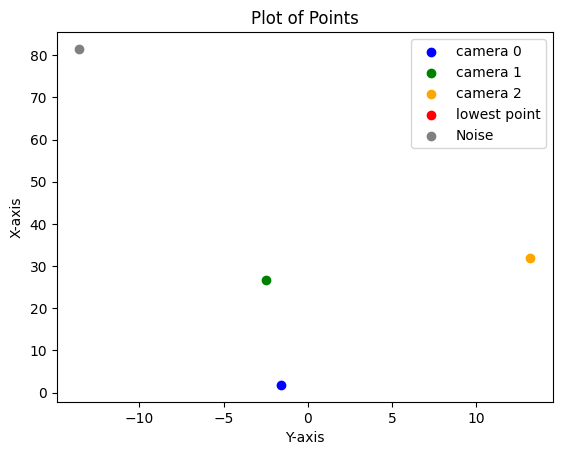

In [23]:
for image, pcd in zip(image_f, pcd_f):
    results = model.predict(image, save=False)
    list_of_pred_boxes = class_box_generator_for_pred(results)
    processed_camera_points_to_ground = camera_to_ground(list_of_pred_boxes, calibration_file_path)


    db_scan = my_custom_dbscan(0.1, 0.5, 2)
    radar_output = db_scan.process_pcd_files(pcd) 
    processed_radar_points_to_ground = radar_to_ground(radar_output, calibration_file_path)

    cluster_on_image = radar_to_camera(radar_output, calibration_file_path)


camera_points_plot = plot_camera_points(processed_camera_points_to_ground)
combined_plot = plot_lp_and_noise(processed_radar_points_to_ground, camera_points_plot)
plt.show(combined_plot)

    

__Forming Matrix and Filtering Cases__

In [24]:
matrix_formation = get_association_matrix(list_of_pred_boxes, cluster_on_image)
filtered_cases = get_filtered_cases(matrix_formation)
print(filtered_cases)

{'many_cluster_to_many_bbox': {'clusters': [], 'pre_boxes': []}, 'many_cluster_to_one_bbox': {'clusters': [], 'pre_boxes': []}, 'one_cluster_to_many_bbox': {'clusters': [], 'pre_boxes': []}, 'one_cluster_to_one_bbox': {'clusters': [], 'pre_boxes': []}, 'unassigned_bbox': {'pre_boxes': [0, 1, 2]}}


__One to One Association__

In [25]:
one_to_one_output = get_one_one_association(filtered_cases)
pprint(one_to_one_output)

{'associated': [], 'non_associated': {'pre_boxes': [0, 1, 2]}}


__One Cluster Many Boxes__

In [26]:
for image, pcd in zip(list_of_images, list_of_pcd_files):
    results = model.predict(image, save=False)
    list_of_pred_boxes = class_box_generator_for_pred(results)
    processed_camera_points_to_ground = camera_to_ground(list_of_pred_boxes, calibration_file_path)


    db_scan = my_custom_dbscan(0.1,0.5, 2)
    radar_output = db_scan.process_pcd_files(pcd) 
    processed_radar_points_to_ground = radar_to_ground(radar_output, calibration_file_path)
    cluster_on_image = radar_to_camera(radar_output, calibration_file_path)
    print(cluster_on_image)

    clusters = cluster_on_image['cluster']
    noise_points = cluster_on_image['noise']

    rgb_image = cv2.imread(image)
 
    for detection in list_of_pred_boxes:
        new_box = expand_bbox(detection[1:5], scale=1.2)
        corner_1 = tuple(map(int, [new_box[0], new_box[1]]))
        corner_2 = tuple(map(int, [new_box[2], new_box[3]]))
        colour = (0, 255, 0)
        thickness_of_box = 3
        cv2.rectangle(rgb_image, corner_1, corner_2, colour, thickness_of_box)

    colour_cluster_centroid = (0, 0, 255)
    colour_noise = (64, 64, 64)
    thickness = -1  # to fill the circle
    radius = 10

    for cluster in clusters:
        centroid = cluster[1]
        cluster_point = tuple(map(int, [centroid[0], centroid[1]]))
        rgb_image = cv2.circle(rgb_image, cluster_point, radius, colour_cluster_centroid, thickness)

    for noise in noise_points:
        noise_centroid = noise[0]
        noise_point = tuple(map(int, [noise_centroid[0], noise_centroid[1]]))
        rgb_image = cv2.circle(rgb_image, noise_point, radius, colour_noise, thickness)

    cv2.imshow('RGB Image', rgb_image)

    # Wait for 500 ms and check if the 'q' key is pressed to exit the loop
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

    # Close the window after finishing the loop
cv2.destroyAllWindows()


image 1/1 E:\THI AIAS\Summer semester\Team project\data assoocation\INFRA-3DRC-Dataset\INFRA-3DRC_scene-09\camera_01\camera_01__data\camera_01__2023-07-06-17-38-47-528.png: 416x640 1 bicycle, 2 cars, 2962.6ms
Speed: 17.3ms preprocess, 2962.6ms inference, 15.7ms postprocess per image at shape (1, 3, 416, 640)
{'cluster': [[[28.308795928955078, -2.417290210723877, -2.5137104988098145], [26.81158447265625, -3.4720230102539062, -3.1305558681488037], [1.2681611776351929]], [[38.0732536315918, 18.28495216369629, -2.665196657180786], [37.88373565673828, 17.04878044128418, -2.6384317874908447], [-2.5856902599334717]]], 'noise': [[[18.406688690185547, 6.575236797332764, -2.390385866165161], [-4.611673355102539]], [[18.752452850341797, 6.920162677764893, -1.5956816673278809], [-4.624191761016846]], [[24.922550201416016, 13.583843231201172, -3.5450680255889893], [1.282705545425415]], [[57.3135986328125, -6.107423782348633, -2.1060259342193604], [4.855676174163818]], [[80.30992889404297, -4.98503

__Many Clusters to one Bounding Box__